# SKIP

In [27]:
import anndata
import os
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import kmapper as km
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from sklearn.decomposition import PCA
import anndata
import os
import numpy as np
import pandas as pd

# SKIP

In [29]:
# Heatmap Generator
def heatmap_generator(input_file, output_dir, title):
    # Load the .h5ad file (replace with your filename)
    input_file = os.path.join('data', 'cancer','dataset.h5ad')
    adata = anndata.read_h5ad(input_file)

    counts = adata.layers['counts']
    counts_df = pd.DataFrame(counts.toarray(), index=adata.obs_names, columns=adata.var_names)
    # convert observations to a DataFrame
    obs_df = adata.obs.copy()
    #Join the counts_df with obs_df
    joined_df = obs_df.join(counts_df, how='inner')
    # Display the first few rows of the joined DataFrame
    print("Joined DataFrame:")
    joined_df.head()
    # make a big df of all the data
    all_data_df = joined_df.copy()

    # drop columns n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,n_genes,size_factors
    all_data_df.drop(columns=['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
                            'log1p_total_counts', 'pct_counts_in_top_50_genes',
                            'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
                            'pct_counts_in_top_500_genes', 'n_genes', 'size_factors'], inplace=True)

    # work with all_data_df
    # change index name to 'id'
    all_data_df.reset_index(inplace=True)
    all_data_df.rename(columns={'index': 'id'}, inplace=True)
    # set index to id, in_tissue, array_row, array_col
    all_data_df.set_index(['id', 'in_tissue', 'array_row', 'array_col'], inplace=True)
    # find top 100 genes with greatest variance
    top_variance_genes = all_data_df.var().nlargest(100)
    # create a new DataFrame with only the top 100 genes
    top_variance_genes_df = all_data_df[top_variance_genes.index]
    # convert the DataFrame to a array
    top_variance_genes_array = top_variance_genes_df.values
    # put x and y coordinates in a array
    xy_coords_df = all_data_df.reset_index()[['array_row', 'array_col']]
    xy_coords_array = xy_coords_df.values
    points = xy_coords_array
    gene_expr = top_variance_genes_array

    spatial_coords = points

    # print types
    print("Points type:", type(points))
    print("Gene expression type:", type(gene_expr))


    # spatial_coords = np.concatenate(points, axis=0)
    # gene_expr = np.concatenate(gene_expr, axis=0)

    # Step 2: PCA on gene expression
    pca = PCA(n_components=2)
    gene_pca = pca.fit_transform(gene_expr)

    # Step 3: Combine spatial and gene PCA data
    combined_data = np.hstack([spatial_coords, gene_pca])

    # Step 4: Persistent homology
    result_spatial = ripser(spatial_coords)
    result_combined = ripser(combined_data)

    # Step 5: Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].set_title("Spatial Persistence")
    plot_diagrams(result_spatial["dgms"], show=False, ax=axs[0])

    axs[1].set_title("Spatial + Gene PCA Persistence")
    plot_diagrams(result_combined["dgms"], show=False, ax=axs[1])

    plt.tight_layout()
    plt.show()
    # convert a list of points to 2 lists of x and y coordinates
    x_coords = [point[0] for point in result_combined["dgms"][1]]
    y_coords = [point[1] for point in result_combined["dgms"][1]]
    coords = np.array([x_coords, y_coords]).T
    #rotate the points by 45 degrees clockwise
    def rotate_points(points, angle_degrees):
        angle_radians = np.radians(angle_degrees)
        rotation_matrix = np.array([[np.cos(angle_radians), -np.sin(angle_radians)],
                                     [np.sin(angle_radians), np.cos(angle_radians)]])
        return points @ rotation_matrix.T
    rotated_points = rotate_points(coords, -45)  # Rotate by -45 degrees

    # Create a 2D histogram (heatmap) of the rotated points
    heatmap, xedges, yedges = np.histogram2d(rotated_points[:, 0], rotated_points[:, 1], bins=50)
    # Create a meshgrid for the heatmap
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(X, Y, heatmap.T, shading='auto', cmap='viridis')
    plt.colorbar(label='Counts')
    plt.title(f'2D Histogram Heatmap of {title}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # set yaxis to 0 - 30
    # plt.gca().set_ylim(bottom=0, top=30)
    # set xaxis to 0 - 100
    plt.gca().set_xlim(left=0, right=100)
    plt.grid()

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    #save the heatmap
    output_file = os.path.join(os.getcwd(), output_dir, f"{title}_heatmap.png")
    plt.savefig(output_file)
    print(f"Heatmap saved to {output_file}")

    plt.show()
    return

# SKIP

In [30]:
def make_mapper(input_file, output_dir, title):

    # Load the .h5ad file (replace with your filename)
    input_file = os.path.join('data', 'cancer','dataset.h5ad')
    adata = anndata.read_h5ad(input_file)

    counts = adata.layers['counts']
    counts_df = pd.DataFrame(counts.toarray(), index=adata.obs_names, columns=adata.var_names)
    # convert observations to a DataFrame
    obs_df = adata.obs.copy()
    #Join the counts_df with obs_df
    joined_df = obs_df.join(counts_df, how='inner')
    # Display the first few rows of the joined DataFrame
    print("Joined DataFrame:")
    joined_df.head()
    # make a big df of all the data
    all_data_df = joined_df.copy()

    # drop columns n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,n_genes,size_factors
    all_data_df.drop(columns=['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
                            'log1p_total_counts', 'pct_counts_in_top_50_genes',
                            'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
                            'pct_counts_in_top_500_genes', 'n_genes', 'size_factors'], inplace=True)

    # work with all_data_df
    # change index name to 'id'
    all_data_df.reset_index(inplace=True)
    all_data_df.rename(columns={'index': 'id'}, inplace=True)
    # set index to id, in_tissue, array_row, array_col
    all_data_df.set_index(['id', 'in_tissue', 'array_row', 'array_col'], inplace=True)
    # find top 100 genes with greatest variance
    top_variance_genes = all_data_df.var().nlargest(100)
    # create a new DataFrame with only the top 100 genes
    top_variance_genes_df = all_data_df[top_variance_genes.index]

    # Step 1: Generate synthetic X10-like gene expression data
    # Simulate 3 clusters of cells in 50-dimensional gene space
    test = top_variance_genes_df.reset_index(drop=True)
    X = StandardScaler().fit_transform(test.values)

    # Convert to DataFrame (simulate genes as columns)
    gene_names = top_variance_genes_df.columns.tolist()
    df = pd.DataFrame(X, columns=gene_names)

    # Step 2: Initialize KeplerMapper
    mapper = km.KeplerMapper(verbose=1)

    # Step 3: Use PCA as lens
    lens = mapper.fit_transform(df, projection=PCA(n_components=2))

    # Step 4: Create a Mapper graph
    graph = mapper.map(
        lens,
        df.values,
        clusterer=DBSCAN(eps=5.0, min_samples=3),
        cover=km.Cover(n_cubes=50, perc_overlap=0.5)
    )

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Step 5: Visualize (save HTML)
    html_path = os.path.join(os.getcwd(), output_dir, f"{title}_mapper.html")
    mapper.visualize(
        graph,
        path_html=html_path,
        title=f"Mapper on X10 Genomic Data ({title})",
    )

    def find_connected_components(graph):
        """
        Find all connected components in an undirected graph represented by an adjacency list.

        Args:
            graph (dict): Dictionary where keys are nodes and values are lists of adjacent nodes.

        Returns:
            list: List of sets, where each set contains nodes in a connected component.
        """
        def dfs(node, visited, component):
            """
            Depth-First Search to explore all nodes in a connected component.

            Args:
                node (str): Current node being explored.
                visited (set): Set of nodes already visited.
                component (set): Current connected component being built.
            """
            visited.add(node)
            component.add(node)
            # Explore all neighbors
            for neighbor in graph.get(node, []):
                if neighbor not in visited:
                    dfs(neighbor, visited, component)

        visited = set()
        components = []

        # Iterate over all nodes to ensure all components are found
        for node in graph:
            if node not in visited:
                current_component = set()
                dfs(node, visited, current_component)
                components.append(current_component)

        # Add isolated nodes (nodes not in graph keys but in values)
        all_nodes = set(graph.keys())
        for neighbors in graph.values():
            all_nodes.update(neighbors)

        for node in all_nodes:
            if node not in visited:
                components.append({node})
                visited.add(node)

        return components

    # Example usage with the provided data
    graph_test = graph['links']

    components = find_connected_components(graph_test)

    print(f"Number of connected components: {len(components)}")
    if len(components) > 6:
        print("I predict cancerous")
    else:
        print("I predict non-cancerous")

    return html_path  # Return path to HTML file

# INPUTS HERE

In [31]:
input_folder = 'data/cancer'
input_file_name = 'dataset.h5ad'
input_file = os.path.join(os.getcwd(), input_folder, input_file_name)
title = 'cancer_dataset'

# RUN MAPPER HER

In [32]:
make_mapper(
    input_file=input_file,
    output_dir='output_html',
    title=title
)

Joined DataFrame:
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: PCA(n_components=2)
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (3460, 100)

..Projecting data using: 
	PCA(n_components=2)


..Scaling with: MinMaxScaler()

Mapping on data shaped (3460, 100) using lens shaped (3460, 2)

Creating 2500 hypercubes.

Created 795 edges and 250 nodes in 0:00:10.731035.
Wrote visualization to: c:\Users\Dzu\Desktop\TDA_cancer\output_html\cancer_dataset_mapper.html
Number of connected components: 8
I predict cancerous


'c:\\Users\\Dzu\\Desktop\\TDA_cancer\\output_html\\cancer_dataset_mapper.html'

# RUN HEAT MAP HERE

Joined DataFrame:
Points type: <class 'numpy.ndarray'>
Gene expression type: <class 'numpy.ndarray'>


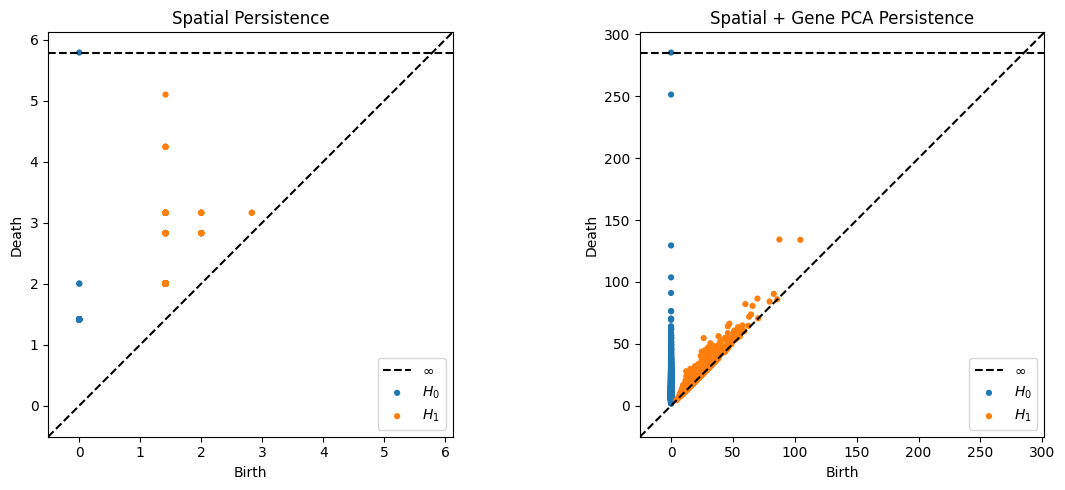

Heatmap saved to c:\Users\Dzu\Desktop\TDA_cancer\output\cancer_dataset_heatmap.png


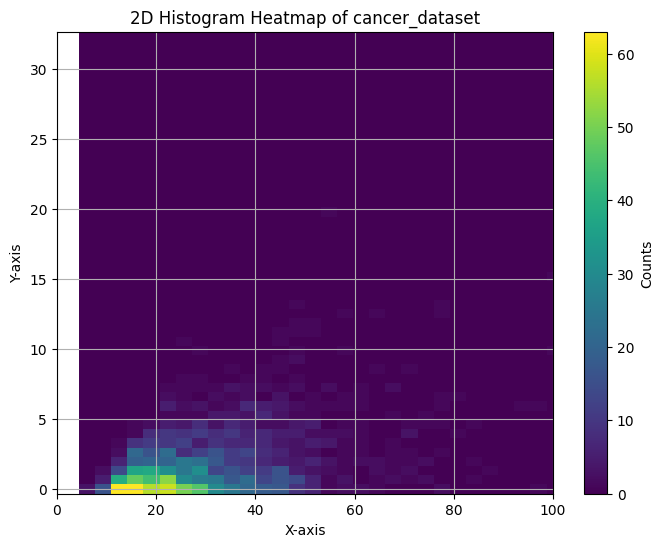

In [33]:
heatmap_generator(
    input_file=input_file,
    output_dir='output',
    title=title
)